In [1]:
import os 
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter, FuncFormatter
import dataframe_image as dfi # for saving styled data frame print-out table as png

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 3.5)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
# set paths and create dirs 
base_dir = '../..'
data_dir = os.path.join(base_dir, 'data')
helper_dir = os.path.join(base_dir, 'helper')
output_dir = os.path.join(base_dir, 'output')
png_dir = os.path.join(output_dir, 'png')
os.makedirs(png_dir, exist_ok=True)

In [3]:
# load helper functions
%run {helper_dir}/plot.py

## Input

In [4]:
chain = 'Avalanche'

In [5]:
fname_fees = 'Fees_2022-01-06_2022-06-29.csv'
fname_swap_src = 'Swap Sources_2022-06-01_2022-06-29.csv'

In [6]:
# create input-dependent dirs
save_fig_dir = os.path.join(png_dir, chain)
os.makedirs(save_fig_dir, exist_ok=True)

## Prep Fees Data

In [7]:
# only read the first 7 cols since the last col "Cumulative" is NOT the daily total, but cumulative daily total, 
# which we don't want.
df_fees = pd.read_csv(os.path.join(data_dir, chain, fname_fees), parse_dates=['Date'], index_col='Date', usecols=range(6))
df_fees.columns = df_fees.columns.str.lower().str.replace(' ', '_') + '_fees'
# calc daily total 
df_fees['total_fees'] = df_fees.sum(axis=1)

print(df_fees.info())
df_fees.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175 entries, 2022-01-06 to 2022-06-29
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   swap_fees            175 non-null    float64
 1   margin_trading_fees  175 non-null    float64
 2   mint_glp_fees        175 non-null    float64
 3   burn_glp_fees        175 non-null    float64
 4   liquidation_fees     175 non-null    float64
 5   total_fees           175 non-null    float64
dtypes: float64(6)
memory usage: 9.6 KB
None


,swap_fees,margin_trading_fees,mint_glp_fees,burn_glp_fees,liquidation_fees,total_fees
Date,,,,,,
2022-01-06,243.7315,"1,841.6199","46,512.0344",61.2569,0.1118,"48,658.7544"
2022-01-07,"8,361.3507","8,681.5863","5,877.2475","1,085.8670","1,456.0469","25,462.0984"
2022-01-08,"12,425.6089","12,073.8660","3,506.1064",957.7285,422.3647,"29,385.6744"
2022-01-09,"13,572.4639","79,978.1430","4,695.0731",181.7615,0.6246,"98,428.0661"
2022-01-10,"23,276.3600","128,402.3029","4,230.0247",242.7791,425.5660,"156,577.0327"


In [8]:
# drop the last row because the most recent date may not be a full day
df_fees = df_fees.iloc[:-1, :]
df_fees.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 174 entries, 2022-01-06 to 2022-06-28
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   swap_fees            174 non-null    float64
 1   margin_trading_fees  174 non-null    float64
 2   mint_glp_fees        174 non-null    float64
 3   burn_glp_fees        174 non-null    float64
 4   liquidation_fees     174 non-null    float64
 5   total_fees           174 non-null    float64
dtypes: float64(6)
memory usage: 9.5 KB


## Where did most fees come from? 

- Margin trading and liquidation fees come from traders.
- GLP minting and burning fees come from GLP liquidity providers.
- Swap fees come from swaps.

In [9]:
da = (df_fees.groupby(df_fees.index.isocalendar().week).sum()
      .assign(trader_fees = lambda x: x.margin_trading_fees + x.liquidation_fees,
              glper_fees = lambda x: x.mint_glp_fees + x.burn_glp_fees,
              swap_fees_pct = lambda x: x.swap_fees / x.total_fees,
              trader_fees_pct = lambda x: x.trader_fees / x.total_fees,
              glper_fees_pct = lambda x: x.glper_fees / x.total_fees)
      .loc[:, ['trader_fees_pct', 'swap_fees_pct', 'glper_fees_pct']])
da.head(10)

,trader_fees_pct,swap_fees_pct,glper_fees_pct
week,,,
1,0.5173,0.1714,0.3114
2,0.8222,0.1083,0.0695
3,0.7892,0.1577,0.0531
4,0.8064,0.1182,0.0754
5,0.6937,0.2097,0.0967
6,0.6641,0.2152,0.1207
7,0.5128,0.2885,0.1986
8,0.6498,0.2621,0.0881
9,0.7080,0.2272,0.0648


In [10]:
start_yr = df_fees.index.min().year 
end_yr = df_fees.index.max().year
if end_yr == start_yr:
    period = '({})'.format(start_yr)
else:
    period = '({} ~ {})'.format(start_yr, end_yr)
period

'(2022)'

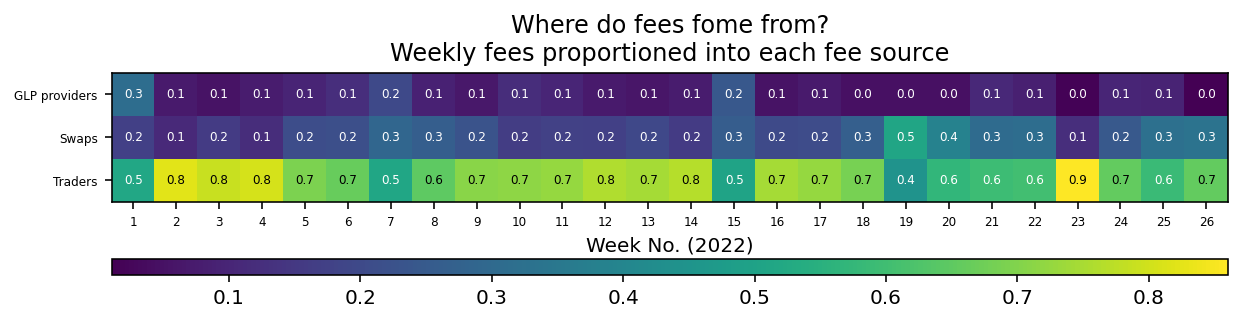

In [11]:
scores_image = heatmap(
    da.T, xlabel='Week No. '+period, 
    ylabel='', xticklabels=da.index,
    yticklabels=da.columns.map({'trader_fees_pct':'Traders', 'swap_fees_pct':'Swaps', 'glper_fees_pct':'GLP providers'}),
    cmap=plt.cm.viridis, fmt='%.1f', text_size=6
)
plt.title("Where do fees fome from?\nWeekly fees proportioned into each fee source") 
plt.colorbar(scores_image, location="bottom", aspect=70)
plt.savefig(os.path.join(save_fig_dir, 'fees_sources.png'), dpi=300);

For most of the time, traders contributed 60% - 80% of the fees, swaps 20% - 30%, and GLP providers 10%. 

In week 1, 30% of the fees came from GLP providers due to a large volume of GLP minting on the first day, when the platform opened to public. It was likely that the team or early investors provided the seed liquidity. For the remaining of the time, fees from GLP providers stayed at below 10% except for week 7 (Feb 14 - 20) and week 15 (Apr 11 - 17), where it was around 20%. 

Swap fees hit 50% and 40% at week 19 and 20 (May 9 - 22), taking shares from traders. Starting at week 18 (May 2 - 8), swap fees regularly stayed around 30% or above, whereas before week 18, swap fees often stayed around 20%. Perhaps 30% is a good level for swap fees. If we begin to see swap fees exceed 40% or 50% week after week, we probably should worry because as the share of swap fees increases, the share of trading-induced fees decreases. Because after all, GMX is not just another DEX, and its business is in leveraged trading. So it's reasonable to expect, by the Pareto Principle, that 70-80% of its revenue comes from trading related activities. 

## Prep Swap Sources Data

In [12]:
df_swap_src = pd.read_csv(os.path.join(data_dir, chain, fname_swap_src), 
                          parse_dates=['Date'], index_col='Date') # , usecols=range(6)
# calc daily total 
df_swap_src['total'] = df_swap_src.sum(axis=1)
# some cols have heavy missings. Don't need to deal them cuz we'll sum and they'll be treated as 0 by default. 

# drop the last row because the most recent date may not be a full day
df_swap_src = df_swap_src.iloc[:-1, :]
print(df_swap_src.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28 entries, 2022-06-01 to 2022-06-28
Data columns (total 32 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Other                                       28 non-null     float64
 1   0xdef1c0ded9bec7f1a1670819833240f027b25eff  28 non-null     float64
 2   0xb40bf51c104cc9e3a45f745e81d3aa9f9e9fc7f4  28 non-null     float64
 3   GMX                                         28 non-null     float64
 4   ParaSwap                                    28 non-null     float64
 5   0xe37f42b5b4f0a537e9b10575f93ca297e9b78ff8  8 non-null      float64
 6   Yak                                         28 non-null     float64
 7   1inch                                       28 non-null     float64
 8   0xc0df1d42c0827aba1d124d19796726c1a2bf3bf8  26 non-null     float64
 9   0x838d26b7324aefc725098111116d9732057aca26  28 non-null     float64
 

In [13]:
period = str(df_swap_src.index.min().date()) + ' ~ ' + str(df_swap_src.index.max().date())

da = (df_swap_src.sum(axis=0))
swap_src_ranked = da.sort_values(ascending=False).to_frame('Swap Volume ($)')
swap_src_ranked['Percent'] = swap_src_ranked['Swap Volume ($)'] / swap_src_ranked.loc['total', 'Swap Volume ($)']
swap_src_ranked.index.name = period

# format as currency and %
format_dict = {'Swap Volume ($)': '${:,.0f}', 'Percent': '{:.1%}'}
swap_src_ranked_styled = swap_src_ranked.head(11).style.format(format_dict)
swap_src_ranked_styled

,Swap Volume ($),Percent
2022-06-01 ~ 2022-06-28,,
total,"$171,190,478",100.0%
1inch,"$44,899,077",26.2%
GMX,"$40,494,824",23.7%
Yak,"$15,958,862",9.3%
0x646bd0a8cfa2fa78e47d6e7d53c8078ad8ceb867,"$11,959,641",7.0%
0xb40bf51c104cc9e3a45f745e81d3aa9f9e9fc7f4,"$10,146,547",5.9%
ParaSwap,"$9,591,786",5.6%
OpenOcean,"$8,546,172",5.0%
0x838d26b7324aefc725098111116d9732057aca26,"$7,905,775",4.6%


In [14]:
# save as png
dfi.export(swap_src_ranked_styled, os.path.join(save_fig_dir, 'swap_volume_by_source.png'))

/usr/local/lib/python3.8/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0629/180223.479240:INFO:headless_shell.cc(660)] Written to file /var/folders/qq/v47zfw7s1kn38gw67q4v194r0000gn/T/tmp5al1v1r9/temp.png.
